# Dominik Adamczyk
## Laboratorium 5 - rozwiązania 

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from queue import Queue
import numpy as np
import cv2
import time

### Aho-Corsaick i wyszukiwanie wzorca 2D

1. Zaimplementuj algorytm wyszukiwania wzorca 2-wymiarowego 

Pierwszym etapem jest zaimplementowanie algorytmu wyszukiwania wielu wzorców na raz poprzez automat Aho-Corasicka.

In [4]:
class Node():
    def __init__(self, value, parent=None, pattern=None):
        self.value = value
        self.parent = parent
        self.pattern = pattern
        self.failure = None
        self.children = {}
        self.index = 0
    
    def add_child(self, child):
        child.parent=self
        if child.value not in self.children.keys():
            self.children[child.value] = child
        return self.children[child.value]
    
    def next_node(self, value):
        if value in self.children:
            return self.children[value]
        current_node = self
        while current_node.index != 0:
            current_node = current_node.failure
            if value in current_node.children:
                return current_node.children[value]
        return current_node
        
class AhoCorasicAutomaton():
    def __init__(self, patterns):
        self.patterns = {pattern: idx for idx, pattern in enumerate(patterns)}
        self.root = Node("")
        self.build_trie()
        self.add_failure_links()

    
    def add_pattern_to_trie(self, pattern, idx):
        i = 0
        node = self.root
        while i < len(pattern) and pattern[i] in node.children.keys():
            node = node.children[pattern[i]]
            i += 1
        while i < len(pattern):
            node = node.add_child(Node(pattern[i]))
            node.index = idx
            idx += 1
            i += 1
        node.pattern=pattern
        self.patterns[pattern] = node.index
        return idx
        
        
    def build_trie(self):
        idx = 1
        for pattern in self.patterns.keys():
            idx = self.add_pattern_to_trie(pattern, idx)
            
    def add_failure_links(self):
        queue = Queue()
        for child in self.root.children.values(): queue.put(child)
        
        while not queue.empty():
            node = queue.get()
            
            for child in node.children.values():
                queue.put(child)
            
            failure_node = node.parent.failure
            
            while failure_node is not None:
                if node.value in failure_node.children.keys() and node != failure_node.children[node.value]:
                    node.failure = failure_node.children[node.value]
                    break
                failure_node = failure_node.failure
            else:
                node.failure = self.root
    
    def visualize(self, title = "", links=False):
        def _add_nodes(G, node):
            G.add_node(node)
            for child in node.children.values():
                _add_nodes(G, child)

        def _add_edges(G, node):
            for child in node.children.values():
                G.add_edge(node, child, color='black')
                _add_edges(G, child)

        def _add_failure(G, node, pos):
            if node.failure is not None:
                G.add_edge(node, node.failure, style = "dashed", color='red')
            for child in node.children.values():
                _add_failure(G, child, pos)
    
        G = nx.DiGraph()
        _add_nodes(G, self.root)
        _add_edges(G, self.root)

        pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
        labels = {node: (node.value, node.index) for node in G.nodes()}
        if links:
            _add_failure(G, self.root, pos)
        e_col = [G[t[0]][t[1]]["color"] for t in G.edges]
        nx.draw_networkx(G, pos=pos, labels=labels, with_labels=True, node_shape='o', edge_color = e_col)
        plt.title(title)
        plt.show()
    

Implementacja umożliwia wizualizację stworzonego drzewa. Wypisywane są litery oraz id każdego z węzłów (id jest używane, gdy dwuwymiarowy tekst zamieniany jest na tablicę stanów). Czarne krawędzie stanowią standardowe połączenia pomiędzy węzłami - struktura drzewa trie. Czerwone krawędzie są połączeniami failure link.

Wypisanie .patterns pozwala zobaczyć wzorce oraz odpowiadające im id.

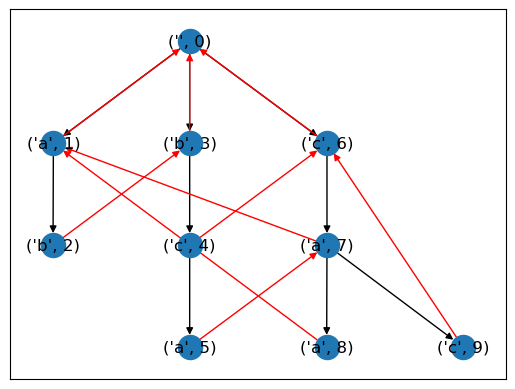

{'ab': 2, 'bca': 5, 'caa': 8, 'cac': 9}


In [5]:
patterns = pattern = ['ab', 'bca', 'caa', 'cac']
T = AhoCorasicAutomaton(patterns)
T.visualize(links=True)
print(T.patterns)

Poniżej znajduje się implementacja dwóch algorytmów szukania wzorców - KMP oraz wzorca 2D.

Wzorzec 2D jest znajdowany poprzez przechodzenie po każdym wierszu tekstu wejściowego i przypisywaniu każdej literze jej stanu na podstawie stworzonego automatu i jego poprzedniego stanu.

Gdy już litery zostaną zamienione na stany dokonywane jest użycie algorytmu kmp na każdej z kolumn dwuwymiarowej tablicy, tak aby dopasować odpowiednie stany, do zredukowanego, jednowymiarowego wzorca obrazującego zadaną kolejność wejściowych wzorców przy pomocy indeksów w drzewie Aho-Corasicka.

In [6]:
def prefix_function(pattern):
    pi = [0]
    k = 0
    for q in range(1, len(pattern)):
        while (k > 0 and pattern[k] != pattern[q]):
            k = pi[k-1]
        if pattern[k] == pattern[q]:
            k = k+1
        pi.append(k)
    return pi

def kmp_string_matching(text, pattern, pi=None):
    if pi is None: pi=prefix_function(pattern)
    q = 0
    results = []
    for i in range(0, len(text)):
        while q > 0 and pattern[q] != text[i]:
            q = pi[q-1]
        if pattern[q] == text[i]:
            q = q + 1
        if q == len(pattern):
            results.append(i - q + 1)
            q = pi[q-1]
    return results

def match_2d_pattern(text, pattern, print_diag=False, timed=False):
    if print_diag:
        print("...pattern...")
        for line in pattern:
            print(line)
        print("\n")
        print("...text...")
        for line in text:
            print(line)
    if timed: t = time.time()
    
    automaton = AhoCorasicAutomaton(pattern)
    
    if timed: 
        bt = time.time() - t
        t = time.time()
    
    max_width = max(len(line) for line in text)
    
    states = [[-1 for _ in range(max_width)] for _ in range(len(text))]
    one_dimension_pattern = [automaton.patterns[p] for p in pattern]
    
    for i, line in enumerate(text):
        node = automaton.root
        for j, letter in enumerate(line):
            node = node.next_node(letter)
            states[i][j] = node.index
            
    result = []
    
    statesT = np.array(states).T.tolist()
    
    for i, line in enumerate(statesT):
        ans = kmp_string_matching(line, one_dimension_pattern)
        for r in ans:
            result.append((i - len(pattern[0]) + 1, r))
    
    if timed:
        return result, bt, time.time()-t
    return result


In [7]:
pattern = ['EF',
           'HI']

text = ['AEEF',
        'HIEF',
        'GEHI',
        'AEFI',
        'AHII']
print("***PATTERN***")
for line in pattern: print("    ", line)
print("\n****TEXT****")
for line in text: print("   ",line)

***PATTERN***
     EF
     HI

****TEXT****
    AEEF
    HIEF
    GEHI
    AEFI
    AHII


In [8]:
match_2d_pattern(text, pattern)

[(1, 3), (2, 1)]

Czyli szukany wzorzec znajduje się dwa razy w tekście, raz w wierszu o indeksie 3 i kolumnie o indeksie 1 (indeksujemy od zera) i raz w wierszu o indeksie 1 i kolumnie o indeksie 2 

### Testy algorytmu

2. Znajdź w załączonym pliku "haystack.txt" wszyskie sytuacje, gdy taka sama litera występuje na tej samej pozycji w dwóch kolejnych linijkach. Zwróć uwagę, na nierówną długość linii w pliku. 


Kwestia nierównej długośći linii została rozwiązana w algorytmie dopasowywania wzorca 2d. Tablica stanów jest dwuwymiarowa i prostokątna, gdzie wymiar w poziomie jest równy długości najdłuższej linii. Jeżeli dana linia jest krótsza od najdłuższej, to ostatnie komórki w tablicy są wypełniane -1, czyli nieistniejącym w automacie stanem.

In [9]:
with open('haystack.txt', 'r') as f:
    text = [line for line in f]

alphabet = set(ch for l in text for ch in l if ch.isalpha())
print(alphabet)

{'Q', 'k', 'u', 'y', 's', 'n', 'G', 'h', 'S', 'v', 'W', 'p', 'g', 'N', 'd', 'x', 'I', 'X', 'O', 'M', 'A', 'T', 'V', 'P', 'a', 'm', 'j', 'r', 'z', 'c', 'E', 'R', 'i', 'q', 't', 'o', 'f', 'F', 'D', 'l', 'L', 'e', 'B', 'C', 'U', 'w', 'b'}


Powyżej znajdują się wszystkie litery w załączonym tekście.

In [10]:
for char in alphabet:
    matched = match_2d_pattern(text, [char, char])
    if len(matched):
        print(f"Letter: {char}, count: {len(matched)}, match places:" )
        for el in matched: print(el, " ", end = "")
        print("\n")

Letter: y, count: 1, match places:
(5, 44)  

Letter: s, count: 19, match places:
(0, 54)  (14, 49)  (21, 8)  (24, 71)  (24, 79)  (34, 37)  (34, 45)  (37, 67)  (41, 70)  (44, 46)  (45, 28)  (49, 4)  (53, 52)  (56, 29)  (56, 30)  (57, 3)  (58, 9)  (63, 3)  (63, 40)  

Letter: n, count: 15, match places:
(1, 31)  (9, 1)  (13, 56)  (18, 35)  (29, 64)  (32, 51)  (33, 54)  (35, 67)  (37, 19)  (40, 67)  (54, 14)  (56, 20)  (57, 67)  (62, 21)  (83, 0)  

Letter: h, count: 4, match places:
(2, 27)  (2, 37)  (12, 73)  (31, 56)  

Letter: p, count: 2, match places:
(18, 41)  (71, 28)  

Letter: d, count: 1, match places:
(19, 37)  

Letter: x, count: 1, match places:
(68, 28)  

Letter: a, count: 28, match places:
(2, 64)  (4, 37)  (6, 20)  (11, 56)  (12, 52)  (12, 53)  (14, 64)  (21, 76)  (22, 64)  (24, 59)  (30, 3)  (35, 65)  (35, 69)  (36, 57)  (36, 58)  (37, 79)  (42, 77)  (48, 53)  (50, 31)  (59, 78)  (60, 5)  (61, 77)  (63, 6)  (66, 33)  (69, 28)  (73, 31)  (74, 76)  (82, 0)  

Letter: m, 

3. Znajdź wszystkie wystąpienia "th" oraz "t h" w dwóch kolejnych liniach na tej samej pozycji. 


In [11]:
pattern = ["th", "th"]
positions = match_2d_pattern(text, pattern)
print(f"found {len(positions)} appearances of pattern {pattern} on positions {positions}")

found 0 appearances of pattern ['th', 'th'] on positions []


In [12]:
pattern = ["t h", "t h"]
positions = match_2d_pattern(text, pattern)
print(f"found {len(positions)} appearances of pattern {pattern} on positions {positions}")

found 1 appearances of pattern ['t h', 't h'] on positions [(0, 37)]


4. Wybierz przynajmniej 4 litery (małe). Znajdź wszystkie wystąpienia tej litery w załączonym pliku "haystack.png" 

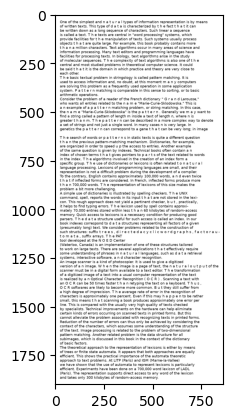

In [13]:
img = cv2.imread("haystack.png")
plt.imshow(img)

In [14]:
def convert_to_tuple_list(img):
    return [[tuple(pixel) for pixel in line] for line in img]
def convert_to_3d_list(img2d):
    return [[list(pixel) for pixel in line] for line in img2d]

In [15]:
def cut_element(img2d, upper_left, lower_right):
    return [[img2d[j][i] for i in range(upper_left[0], lower_right[0])] for j in range(upper_left[1], lower_right[1])]

Funkcja służąca do znajdowania danej litery i porównywania wyników: przy użyciu algorytmu na obrazie, przy użyciu na tekście, przy sprawdzeniu naiwnie.

In [37]:
def find_letter(image, upper_left, lower_right, letter):
    letterimg = cut_element(image, upper_left, lower_right)
    for i in range(len(letterimg)):
        letterimg[i] = tuple(letterimg[i])
    plt.imshow(convert_to_3d_list(letterimg))
    positions = match_2d_pattern(image, letterimg)
    t = "letter" if len(letter) == 1 else "text"
    print(f"{t} '{letter}' found {len(positions)} times on image")
    positions = match_2d_pattern(text, [letter])
    print(f"{t} '{letter}' found {len(positions)} times in text")
    i = 0
    for line in text: 
        # for l in line: 
        i+= len(kmp_string_matching(line, letter))
            # if l == letter: i += 1
    print(f"{t} '{letter}' appears {i} times in text")

letter 'a' found 397 times on image
letter 'a' found 397 times in text
letter 'a' appears 397 times in text


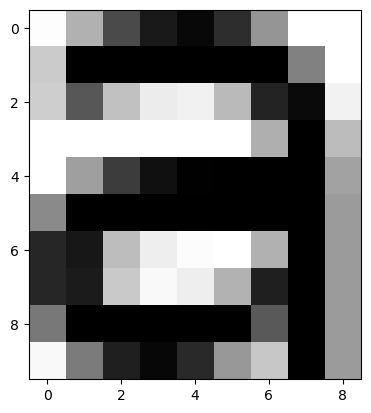

In [38]:
img2d = convert_to_tuple_list(img)
find_letter(img2d, (26,367), (35,377), "a")


letter e found 576 times on image
letter e found 583 times in text
letter e appears 583 times in text


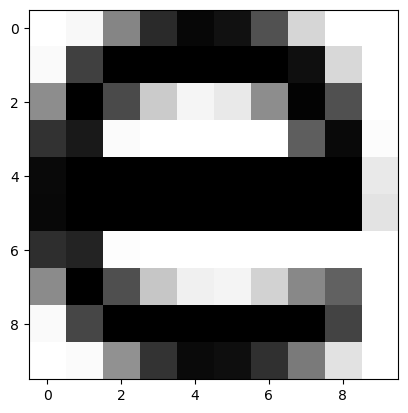

In [33]:
find_letter(img2d, (44,367), (54,377), "e")

letter s found 334 times on image
letter s found 334 times in text
letter s appears 334 times in text


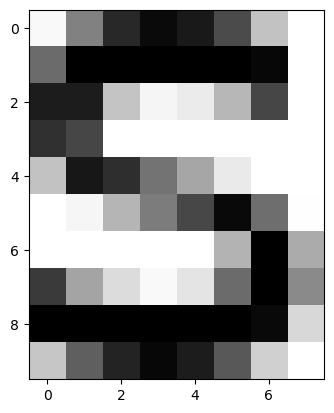

In [34]:
find_letter(img2d, (61,367), (69,377), "s")

letter n found 339 times on image
letter n found 339 times in text
letter n appears 339 times in text


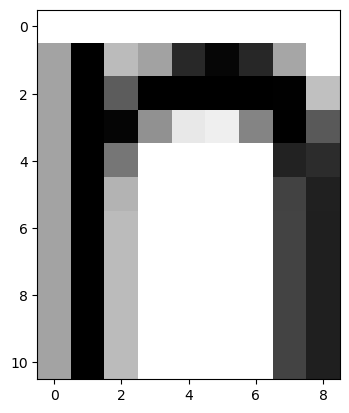

In [35]:
find_letter(img2d, (102,366), (111,377), "n")

W powyższym teście trzy litery znalazły poprawną liczbę dopasowań, nie stało się tak dla litery "e" przy dopasowywaniu obrazu. Jest to spowodowane faktem, że zaimplementowany algorytm szuka jedynie w 100% takich samych dopasowań - nawet minimalna zmiana koloru na jednym pixelu szukanego obrazu powoduje, że znalezienie wzorca jest uniemożliwione.

5. Znajdź wszystkie wystąpienia słowa "p a t t e r n" w haystack.png. 

text p a t t e r n found 5 times on image
text p a t t e r n found 5 times in text
text p a t t e r n appears 5 times in text


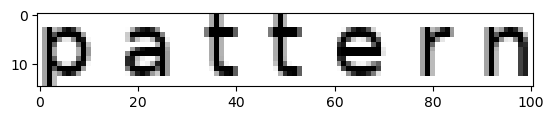

In [36]:
find_letter(img2d, (241, 540), (342, 555), "p a t t e r n")

6. Porównaj czas budowania automatu i czas wyszukiwania dla różnych rozmiarów wzorca 

W poniższym teście wzorzec jest kwadratem o boku n. Testy są przeprowadzane na pliku haystack.png

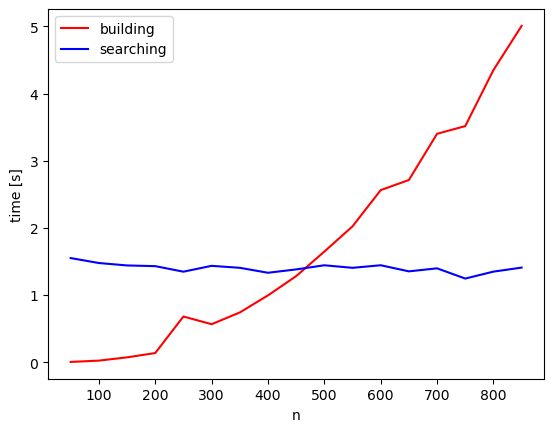

In [39]:
def compare_times():
    build = []
    search = []
    max_n = len(img2d[0])
    ns = list(range(50, max_n, 50))
    
    for n in ns:
        el = cut_element(img2d, (0, 0), (n, n))
        for e in range (len(el)):
            el[e] = tuple(el[e])
        _, bt, st = match_2d_pattern(img2d, el, timed=True)
        build.append(bt)
        search.append(st)
    # print(ns, build_times)
    _, ax = plt.subplots(1)
    ax.plot(ns, build, label='building', color='red')
    ax.plot(ns, search, label='searching', color='blue')
    ax.legend()
    ax.set_ylabel('time [s]')
    ax.set_xlabel('n')

compare_times()

Zgodnie z oczekiwaniami czas budowy automatu rośnie liniowo względem rozmiaru wzorca (czyli kwadratowo względem n - długości w jednym wymiarze). Czas przeszukiwania jest natomiast liniowo zależny od rozmiaru przeszukiwanego tekstu, w tym wypadku przeszukiwanym "tekstem" jest obraz, którego rozmiar się nie zmienia w czasie.

7. Podziel plik na 2, 4 i 8 fragmentów (w poziomie) i porównaj czas przeszukiwania 

In [40]:
def compare_divided(image, pieces_no, pattern_size):
    division_len = len(image) // pieces_no
    pieces = [cut_element(image, (0, i * division_len), (len(image[0]), (i+1) * division_len)) for i in range(pieces_no)]
    # for i in range(pieces_no):
    #     for e in range (len(pieces[i])):
    #         pieces[i][e] = tuple(pieces[i])
    pattern = cut_element(image, (0, 0), (pattern_size, pattern_size))
    for e in range (len(pattern)):
        pattern[e] = tuple(pattern[e])
    full_time = 0
    for piece in pieces:
        _, _, t = match_2d_pattern(piece, pattern, timed=True)
        full_time += t
    return full_time

Pieces number: 1, search time 1.481999158859253
Pieces number: 2, search time 1.4443655014038086
Pieces number: 4, search time 1.55324125289917
Pieces number: 8, search time 1.474724531173706


Text(0, 0.5, 'Time [s]')

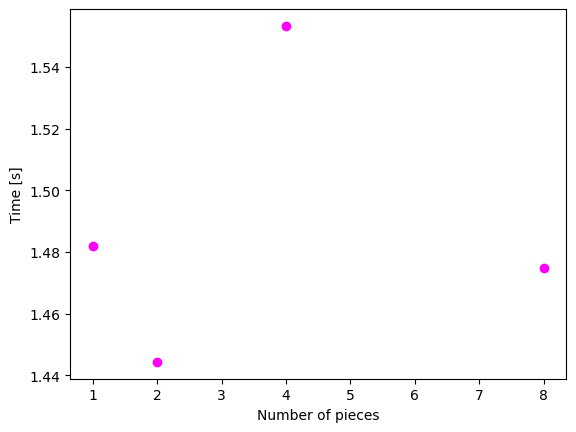

In [46]:
st = []
vals = [1, 2, 4, 8]
for i in vals:
    st.append(compare_divided(img2d, i, 50))
    print(f"Pieces number: {i}, search time {st[-1]}")
plt.plot(vals, st, 'o', color='magenta')
plt.xlabel("Number of pieces")
plt.ylabel("Time [s]")

Podzelenie pliku na wiele fragmentów nie skutkuje zmianami w czasie wykonania algorytmu - w powyższym teście różnice między namniejszym, a największym czasem są na poziomie 1%. Takie zachowanie jest oczekiwane, gdyż sumaryczna długość tekstu nie ulega zmianie, a czas działania algorytmu jest zależny od tej wartości.

Takie podzielenie może jednak skutkować niepoprawnymi wynikami, gdyż algorytm nie jest w stanie dopasować wzorca znajdującego się na miejscu przecięcia dwóch części tekstu (o ile tego typu wzorzec jest szukany).